# Benchmarking bounded sub-optimal A* algorithm

### Goal
In this lab, we will consider the problem of benchmarking of sub-optimal A* algorithm with different weights.

The sub-optimal A* algorithm is a modification of the original A* algorithm, where it sacrifices optimality for improved computational efficiency. It does this by introducing a weight factor that affects the cost calculation during pathfinding. In this benchmarking exercise, we will consider following different weight values: *1.05, 1.1, 1.5, 2, 3, 5* and 1 for default A*.


### Test setup

To benchmark this sub-optimal A* algorithm, we will perform a series of tests on different maps or grids with varying complexities and sizes form [MovingAI](https://movingai.com/benchmarks/grids.html) dataset. Each test will involve finding the shortest path from a given start node to a goal node using the sub-optimal A* algorithm the octile heuristic and the different weight values.

During the benchmarking process, we will measure several key metrics to assess the algorithm's performance. These metrics may include:
- Path length
- Execution time
- Search tree size
- Path length correctness


Benchmarking will be performed on three random map form different datasets of MovingAI:
- "DAO" map : big empty space, few obstacles and almost straightforward paths.
- "Maze" map : small empty space, a lot of obstacles and branches with tough topology.  
- "Street" map : medium empty space, the obstacles are commonly linear segments, the paths are smoothed polygonal chains.

### Conclusion
The benchmarking findings demonstrate that the bounded sub-optimal A* algorithm performs competitively compared to the original A* in terms of solution quality and runtime efficiency. It proves to be a good approach for solving optimization problems, particularly in scenarios where search speed is important and the optimality of solutiond comes second. The algorithm's ability to provide reasonably good solutions within a bounded sub-optimality bound makes it suitable for real-time applications where approximate solutions are acceptable. 

*All the graphs and plots are at the end of Jupyter Notebook*



In [27]:
import json
import traceback
from heapq import heappop, heappush
from pathlib import Path
from textwrap import dedent
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from PIL import Image, ImageDraw

%matplotlib inline

## Grid Map Representation

In [28]:
class Map:
    """
    Represents a square grid environment for our moving agent.

    Attributes
    ----------
    _width : int
        The number of columns in the grid.

    _height : int
        The number of rows in the grid.

    _cells : np.ndarray
        A binary matrix representing the grid where 0 represents a traversable cell, and 1 represents a blocked cell.
    """

    def __init__(self, cells: npt.NDArray):
        """
        Initializes the map using a 2D array of cells.

        Parameters
        ----------
        cells : np.ndarray
            A binary matrix representing the grid. 0 indicates a traversable cell, and 1 indicates a blocked cell.
        """
        self._width = cells.shape[1]
        self._height = cells.shape[0]
        self._cells = cells

    def in_bounds(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is within the grid boundaries.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is inside the grid, False otherwise.
        """
        return 0 <= j < self._width and 0 <= i < self._height

    def traversable(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is not an obstacle.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is traversable, False if it's blocked.
        """
        return not self._cells[i, j]
    
    def edge_cut(self, i: int, j: int, di: int, dj: int):
        """
        Checks if the diagonal move (i+di, j+dj) has no edge cuts

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.
        di : int
            Offset for the row.
        dj : int
            Offset for the column.

        Returns
        ----------
        bool
            True if there are no edge cuts, False otherwise
        """
        return self.traversable(i + di, j) and self.traversable(i, j + dj)

    def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
        """
        Gets a list of neighboring cells as (i, j) tuples.
        Assumes that the grid is 4-connected, allowing moves only in cardinal directions.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        neighbors : List[Tuple[int, int]]
            List of neighboring cells.
        """
        neighbors = []
        delta = ((0, 1), (1, 0), (0, -1), (-1, 0), (1,1), (1,-1), (-1,1), (-1,-1))
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if self.in_bounds(ni, nj) and self.traversable(ni, nj) and self.edge_cut(i, j, dx, dy):
                neighbors.append((ni, nj))
        return neighbors

    def get_size(self) -> Tuple[int, int]:
        """
        Returns the size of the grid in cells.

        Returns
        ----------
        (height, width) : Tuple[int, int]
            Number of rows and columns in the grid.
        """
        return self._height, self._width

In [29]:
def convert_string_to_cells(cell_str: str) -> npt.NDArray:
    """
    Converts a string representation of a grid map, with '@', 'O', 'T', 'S', 'W', '#' for obstacles and
    '.', 'G' for free cells, into a binary matrix.

    Parameters
    ----------
    cell_str : str
        String containing grid map information ('#' for obstacles and '.' for free cells).

    Returns
    ----------
    cells : np.ndarray
        Binary matrix representing the grid map.
    """
    lines = cell_str.replace(" ", "").split("\n")

    terrain_legend = {
        '.': 0,
        'G': 0,
        '@': 1,
        'O': 1,
        'T': 0,
        'S': 1,
        'W': 1,
        '#': 1
    }
    cells = np.array(
        [[terrain_legend[char] for char in line] for line in lines if line],
        dtype=np.int8,
    )
    return cells

Computes the cost of a transition from cell `(i1, j1)` to cell `(i2, j2)`. In the case of a 4-connected grid, the cost is always equal to 1. Consequently, the cost of each path is an integer.

However, please note that if the grid's connectivity exceeds 4, the cost of a transition may vary and may become fractional or even arbitrary (e.g., $\sqrt{2}$ for diagonal moves).

Recall that in this lab, we assume a 4-connected grid, meaning that only cardinal moves (up, down, left, right) are allowed, and as a result, all costs are integers.


In [30]:
def compute_cost(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]:
    """
    Computes the cost of simple moves between cells (i1, j1) and (i2, j2).

    Parameters
    ----------
    i1 : int
        Row number of the first cell in the grid.
    j1 : int
        Column number of the first cell in the grid.
    i2 : int
        Row number of the second cell in the grid.
    j2 : int
        Column number of the second cell in the grid.

    Returns
    ----------
    int | float
        Cost of the move between cells.

    Raises
    ----------
    ValueError
        If trying to compute the cost of a non-supported move (only cardinal moves are supported).
    """
    if abs(i1 - i2) + abs(j1 - j2) == 1:  # Cardinal move
        return 1
    elif abs(i1 - i2) == 1 and abs(j1 - j2) == 1: # Diagonal move
        return 1.414213
    else:
        raise ValueError("Trying to compute the cost of a non-supported move! ONLY cardinal moves are supported.")

## Search Node

A Search node is a fundamental concept in heuristic search algorithms. It encapsulates data about the state of the problem (e.g., the position of a robot or agent on a grid) and the information needed to construct a search tree, including g-values, h-values, f-values, and a backpointer to its predecessor.


In [31]:
class Node:
    """
    Represents a search node.

    Attributes
    ----------
    i : int
        Row coordinate of the corresponding grid element.
    j : int
        Column coordinate of the corresponding grid element.
    g : float | int
        g-value of the node.
    h : float | int
        h-value of the node
    f : float | int
        f-value of the node
    parent : Node
        Pointer to the parent node.
    """

    def __init__(
        self,
        i: int,
        j: int,
        g: Union[float, int] = 0,
        h: Union[float, int] = 0,
        f: Optional[Union[float, int]] = None,
        parent: "Node" = None,
        w: Optional[float] = 1
    ):
        """
        Initializes a search node.

        Parameters
        ----------
        i : int
            Row coordinate of the corresponding grid element.
        j : int
            Column coordinate of the corresponding grid element.
        g : float | int
            g-value of the node.
        h : float | int
            h-value of the node (always 0 for Dijkstra).
        f : float | int
            f-value of the node (always equal to g-value for Dijkstra).
        parent : Node
            Pointer to the parent node.
        w : float
            weight value of the heuristic (always equal 1 for default A*)
        """
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        self.w = w
        if f is None:
            self.f = self.g + w * h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other):
        """
        Checks if two search nodes are the same, which is needed to detect duplicates in the search tree.
        """
        return (self.i, self.j) == (other.i, other.j)

    def __hash__(self):
        """
        Makes the Node object hashable, allowing it to be used in sets/dictionaries.
        """
        return hash((self.i, self.j))

    def __lt__(self, other):
        """
        Compares the keys (i.e., the f-values) of two nodes, needed for sorting/extracting the best element from OPEN.
        """
        return self.f < other.f

## A* Algorithm

Implementing the Search Tree (i.e., OPEN and CLOSED) and `A*` algorithm.

In [32]:
class SearchTreePQD:
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = dict()  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_duplicates = 0  # Number of duplicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        while True:
            if not self._open:
                return None
            
            best_node = heappop(self._open)
            
            if self.was_expanded(best_node): # node was expanded
                self._enc_open_duplicates += 1
                continue

            return best_node

    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[item] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return item in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_duplicates(self):
        return self._enc_open_duplicates

The input for the `A*` algorithm is:
- map representation
- start/goal cells
- heuristic function $^*$
- a reference to the implementation of the SearchTree

The output is:
- path found flag (`true` or `false`)
- last node of the path (so one can unwind it using the parent-pointers and get the full path)
- the number of steps (iterations of the main loop)
- the number of nodes that compose the search tree at the final iteration of the algorithm (=the size of the resultant search tree)
- OPEN and CLOSED (as iterable collections of nodes) for further visualization purposes
- REEXPANDED (as iterable collections of nodes) for further visualization purposes


PS: You might also want to display, at the final iteration, the number of OPEN duplicates encountered during the search, as shown below:

```python
print("During the search, the following number of OPEN dublicates was encountered: ", ast.number_of_open_duplicates) 
print("During the search, the following number of reexpanded nodes was encountered ", ast.number_of_reexpansions)
```


In [33]:
def astar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implements the A* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
    """
    ast = search_tree()
    steps = 0

    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    ast.add_to_open(start_node)

    while not ast.open_is_empty():
        steps += 1
        current_node = ast.get_best_node_from_open()

        # in lazy impementation we may expand all nodes, but duplicates are still exists
        if current_node is None:
            break

        if (current_node.i, current_node.j) == (goal_i, goal_j):
            return True, current_node, steps, len(ast), ast.opened, ast.expanded
        
        for neighbor_i, neighbor_j in task_map.get_neighbors(current_node.i, current_node.j):
            neighbor_g = current_node.g + compute_cost(current_node.i, current_node.j, neighbor_i, neighbor_j)
            neighbor_h = heuristic_func(neighbor_i, neighbor_j, goal_i, goal_j)  
            neighbor_node = Node(neighbor_i, neighbor_j, g=neighbor_g, h=neighbor_h, parent=current_node)
            
            if not ast.was_expanded(neighbor_node):
                ast.add_to_open(neighbor_node)
        
        ast.add_to_closed(current_node)
  

    return False, None, steps, len(ast), None, ast.expanded

## WA*

The output for the `WA*` algorithm is the same as for the `A*`, but in input we add additional parameter *weight*.

In [34]:
def wastar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
    weight: float
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implements the WA* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.
    weight : float
        Sub-optimal factor of WA*.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
    """
    ast = search_tree()
    steps = 0

    if weight < 1:
        raise ValueError("Heuristic weight must be >= 1")

    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    ast.add_to_open(start_node)

    while not ast.open_is_empty():
        steps += 1
        current_node = ast.get_best_node_from_open()

        # in lazy impementation we may expand all nodes, but duplicates are still exists
        if current_node is None:
            break

        if (current_node.i, current_node.j) == (goal_i, goal_j):
            return True, current_node, steps, len(ast), ast.opened, ast.expanded
        
        for neighbor_i, neighbor_j in task_map.get_neighbors(current_node.i, current_node.j):
            neighbor_g = current_node.g + compute_cost(current_node.i, current_node.j, neighbor_i, neighbor_j)
            neighbor_h = heuristic_func(neighbor_i, neighbor_j, goal_i, goal_j)  
            neighbor_node = Node(neighbor_i, neighbor_j, g=neighbor_g, h=neighbor_h, w=weight, parent=current_node)
            
            if not ast.was_expanded(neighbor_node):
                ast.add_to_open(neighbor_node)
        
        ast.add_to_closed(current_node)
  

    return False, None, steps, len(ast), None, ast.expanded

## Heuristic

We will use octile heuristic function which is admissible and monotone.

In [35]:
def octile_distance(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]:
    """
    Computes the Octile(diagonal) distance between two cells on a grid.

    Parameters
    ----------
    i1, j1 : int
        (i, j) coordinates of the first cell on the grid.
    i2, j2 : int
        (i, j) coordinates of the second cell on the grid.

    Returns
    -------
    float
        Octile distance between the two cells.
    """
    dx = abs(i1 - i2)
    dy = abs(j1 - j2)
    card_cost = 1
    diag_cost = 1.41423
    return card_cost * max(dx, dy) + (diag_cost - card_cost) * min(dx, dy)

## Visualization

In [36]:
def draw_rectangle(draw, node, scale, color):
    """Draws a rectangle on the grid, given the node and the desired color."""
    draw.rectangle(
        (
            node.j * scale,
            node.i * scale,
            (node.j + 1) * scale - 1,
            (node.i + 1) * scale - 1,
        ),
        fill=color,
        width=0,
    )


def draw(
    grid_map: Map,
    start: Optional[Node] = None,
    goal: Optional[Node] = None,
    path: Optional[Iterable[Node]] = None,
    nodes_discovered: Optional[Iterable[Node]] = None,
    nodes_expanded: Optional[Iterable[Node]] = None,
    nodes_reexpanded: Optional[Iterable[Node]] = None,
):
    """
    Visualizes the environment, path, and expanded/not yet expanded/re-expanded nodes.

    Parameters
    ----------
    grid_map : Map
        Environment represented as a grid.
    start, goal : Optional[Node], Optional[Node]
        Nodes for the start and goal positions of the agent.
    path : Optional[Iterable[Node]]
        Sequence of nodes representing the path between start and goal.
    nodes_discovered : Optional[Iterable[Node]]
        Nodes that were discovered during the search process.
    nodes_expanded : Optional[Iterable[Node]]
        Nodes that were expanded during the search process.
    nodes_reexpanded : Optional[Iterable[Node]]
        Nodes that were re-expanded during the search process.
    """
    scale = 5
    height, width = grid_map.get_size()
    im = Image.new("RGB", (width * scale, height * scale), color="white")
    draw = ImageDraw.Draw(im)

    # Draw blocked cells
    for i in range(height):
        for j in range(width):
            if not grid_map.traversable(i, j):
                draw.rectangle(
                    (j * scale, i * scale, (j + 1) * scale - 1, (i + 1) * scale - 1),
                    fill=(70, 80, 80),
                )

    node_colors = [
        (nodes_discovered, (213, 219, 219)),
        (nodes_expanded, (131, 145, 146)),
        (nodes_reexpanded, (255, 145, 146)),
    ]

    for nodes, color in node_colors:
        if nodes is not None:
            for node in nodes:
                draw_rectangle(draw, node, scale, color)

    if path is not None:
        for step in path:
            color = (52, 152, 219) if grid_map.traversable(step.i, step.j) else (230, 126, 34)
            draw_rectangle(draw, step, scale, color)

    if start is not None and grid_map.traversable(start.i, start.j):
        draw_rectangle(draw, start, scale, (40, 180, 99))

    if goal is not None and grid_map.traversable(goal.i, goal.j):
        draw_rectangle(draw, goal, scale, (231, 76, 60))

    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

## Maps data gathering and processing

In [37]:
def make_path(goal: Node) -> Tuple[List[Node], Union[float, int]]:
    """
    Creates a path by tracing parent pointers from the goal node to the start node.
    It also returns the path's length.

    Parameters
    ----------
    goal : Node
        Pointer to the goal node in the search tree.

    Returns
    -------
    Tuple[List[Node], float]
        Path and its length.
    """
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [38]:
def read_task_from_file(
    path: str,
) -> List[Tuple[npt.NDArray, int, int, int, int, float]]:
    """
    Reads map, start/goal positions, and true value of path length between the given start and goal from a file.

    Parameters
    ----------
    path : str
        Path to a file with the pathfinding problem instance.

    Returns
    -------
    cells : npt.NDArray
        Matrix of grid map cells.
    start_i, start_j : int, int
        Position of the start cell in the grid.
    goal_i, goal_j : int, int
        Position of the goal cell in the grid.
    length : float
        True value of the path's length between the given start and goal.
    """
    cells = None
    
    with open(path) as map_file:
        type = next(map_file)
        height = int(next(map_file).split()[1]) # <- "height ***"
        width = int(next(map_file).split()[1]) # <- "width ***"

        # Read the map section
        map = next(map_file)
        map_lines = [next(map_file) for _ in range(height)]
        map_str = "\n".join(map_lines)
        cells = convert_string_to_cells(map_str)

    path = path.split('/') # expected path = .../data/*-map/*.map
    path[-2] = path[-2].replace('map', 'scen')
    path[-1] += '.scen'
    path = '/'.join(path) # -> expected outup path = .../data/*-scen/*.map.scen
    
    data = []
    with open(path) as task_file:
        for line in task_file.readlines()[1:]:    # 0	maze512-1-0.map	512	512	477	130	476	131	2.00000000
            difficulty, name, h, w, start_i, start_j, goal_i, goal_j, lenght = line.split()
            data.append([cells, int(start_j), int(start_i), int(goal_j), int(goal_i), float(lenght)])  # cells, start_i, start_j, goal_i, goal_j, length

    return data

When you finish implementing search algorithms, you'll naturally want to test them. The following functions will help you in doing just that.

`simple_test` runs the pathfinding algorithm on a single, straightforward instance, while `massive_test` executes it on a series of more involved instances. Both tests operate under the assumption that the search function follows the pattern below:

```
search(task_map, start.i, start.j, goal.i, goal.j, *optional arguments*) -> (path_found, last_state, steps, search_tree_size, open, closed)
```

These automated tests anticipate that the search function, which is passed as an input, adheres to the following structure:

- `task_map` is the grid
- `start.i, start.j` are the  $(i, j)$ coordinates of the starting cell
- `goal.i, goal.j` are the $(i, j)$ coordinates of the goal cell
- `*optional arguments*` represent additional parameters of the search function, passed with *args. For instance, the heuristic function.
- `path_found` is `True` if a path was found and `False` otherwise
- `last_state` denotes the last state of the path. It returns `None` if a path was not found
- `steps` provides the number of search steps taken
- `search_tree_size` represents the number of nodes that make up the search tree at the final iteration of the algorithm, which equates to the size of the resultant search tree.
- `open` is an iterable collection of the nodes that form the search frontier (OPEN nodes)
- `closed` is an iterable collection of the expanded nodes (CLOSED)


In [39]:
def simple_test(search_function: Callable, task: Union[int, None], data_path: str, *args):
    """
    Function `simple_test` runs `search_function` on one task. Use a number to choose a specific debug task
    on a simple map, or use None to select a random task from this pool. The function displays:
     - 'Path found!' and some statistics if a path was found.
     - 'Path not found!' if a path was not discovered.
     - 'Execution error' if an error occurred during the execution of the search_function.
    In the first case, the function also provides a visualization of the task.

    Parameters
    ----------
    search_function : Callable
        Implementation of the search method.
    task : int | None
        A number from 0 to 24 to choose a specific debug task on a simple map,
        or None to select a random task from this pool.
    *args
        Additional arguments passed to the search function.
    """
    
    task_list = read_task_from_file(data_path)
    
    cells, start_i, start_j, goal_i, goal_j, length = task_list[task]
    
    task_map = Map(cells)
    start = Node(start_i, start_j)
    goal = Node(goal_i, goal_j)
    
    try:
        (
            found,
            end_node,
            number_of_steps,
            search_tree_size,
            *other_results,
        ) = search_function(task_map, start.i, start.j, goal.i, goal.j, *args)

        if found:
            path, path_length = make_path(end_node)
            correct = int(path_length) == int(length)
            draw(task_map, start, goal, path, *other_results)
            print(
                f"Path found! Length: {path_length}. Search tree size: {search_tree_size}. Number of steps: {number_of_steps}. Correct: {correct}"
            )
        else:
            print("Path not found!")
        return

    except Exception as e:
        print(f"Execution error: {e}")
        traceback.print_exc()

In [40]:
from os import listdir
import time
def massive_test(search_function, data_path, seed, *args) -> Dict:
    """
    The `massive_test` function runs the `search_function` on a set of different tasks
    (for example, from the directory `data/`) using *args as optional arguments.
    For every task, it displays a short report:
     - 'Path found!' along with some statistics if a path was found.
     - 'Path not found!' if a path wasn't found.
     - 'Execution error' if an error occurred during the execution of the search_function.

    The function returns a dictionary containing statistics with the following keys:
     - "corr" — correctness of each path length (True/False).
     - "len" — the length of each path (0.0 if a path wasn't found).
     - "st_size" — the size of the resultant search tree for each task.
     - "steps" — the number of algorithm steps for each task.

    Parameters
    ----------
    search_function : Callable
        The implemented search method.
    data_path : str
        Path to the directory containing tasks.
    num_of_tasks : int
        The number of tasks to be used for evaluation.

    Returns
    -------
    stat : Dict
        A dictionary containing statistics.

    """
    stat = {
        "corr": [],
        "len": [],
        "st_size": [],
        "steps": [],
        "time": [],
        "map_name": []
    }

    num_of_tasks = 100

    np.random.seed(seed)

    l = {0: 'dao', 1: 'maze', 2: 'street'}
    task_folder = f"{data_path}{l[seed % 3]}-map/"

    for filename in listdir(task_folder):
        if not filename.endswith('.map'):
            continue

        task_list = read_task_from_file(task_folder + filename) 
        n = len(task_list)

        task_id = 0
        random_tasks = sorted(np.random.randint(0, n, size=num_of_tasks))
        for i in random_tasks:
            task_id += 1
            cells, start_i, start_j, goal_i, goal_j, length = task_list[i]
            
            task_map = Map(cells)
            try:
                start_time = time.time()
                (
                    found,
                    end_node,
                    number_of_steps,
                    search_tree_size,
                    *other_results,
                ) = search_function(task_map, start_i, start_j, goal_i, goal_j, *args)
                end_time = time.time()
                if found:
                    _, path_length = make_path(end_node)
                    correct = int(path_length) == int(length)

                    # print(
                    #     f"Task: #{task_id}. Path found! Length: {path_length}. Search tree size: {search_tree_size}. "
                    #     f"Number of steps: {number_of_steps}. Correct: {correct}"
                    # )

                    stat["len"].append(path_length)
                    stat["corr"].append(correct)
                else:
                    print(f"Task: #{task_id}. Path not found!")
                    stat["len"].append(0.0)
                    stat["corr"].append(False)

                stat["st_size"].append(search_tree_size)
                stat["steps"].append(number_of_steps)
                stat["time"].append(end_time - start_time)
                stat["map_name"].append(filename)
            except Exception as e:
                print(f"Execution error: {e}")
                traceback.print_exc()
            
        break

    return stat

## A* and Tie-breakers

The influence of tie-breaking criteria can significantly affect the performance of A*.

Let's implement two different secondary criteria (when the f-value is the same, we'll consider the g-value) and see which one performs better.


In [41]:
def lt_g_max(self, other):
    if self.f == other.f:
        return self.g > other.g
    return self.f < other.f


def lt_g_min(self, other):
    if self.f == other.f:
        return self.g < other.g
    return self.f < other.f

Node.__lt__ = lt_g_max
# Node.__lt__ = lt_g_min

## Simple Test

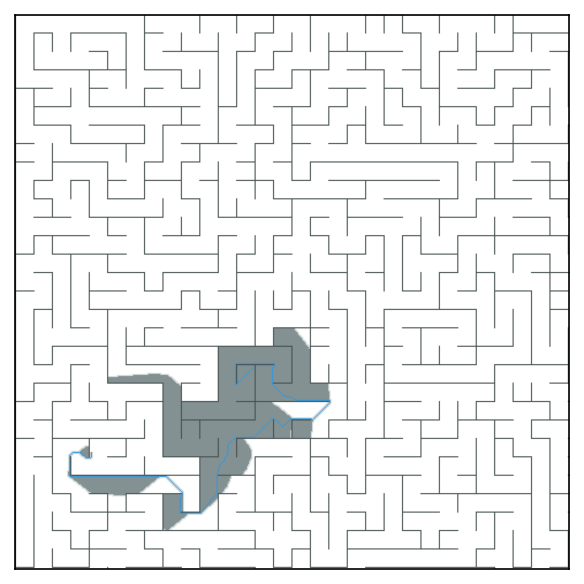

Path found! Length: 545.5756070000007. Search tree size: 15877. Number of steps: 13704. Correct: False
CPU times: user 1.96 s, sys: 48.6 ms, total: 2.01 s
Wall time: 2.03 s


In [42]:
%time res = simple_test(wastar, 1337, 'data/maze-map/maze512-16-0.map', octile_distance, SearchTreePQD, 2)

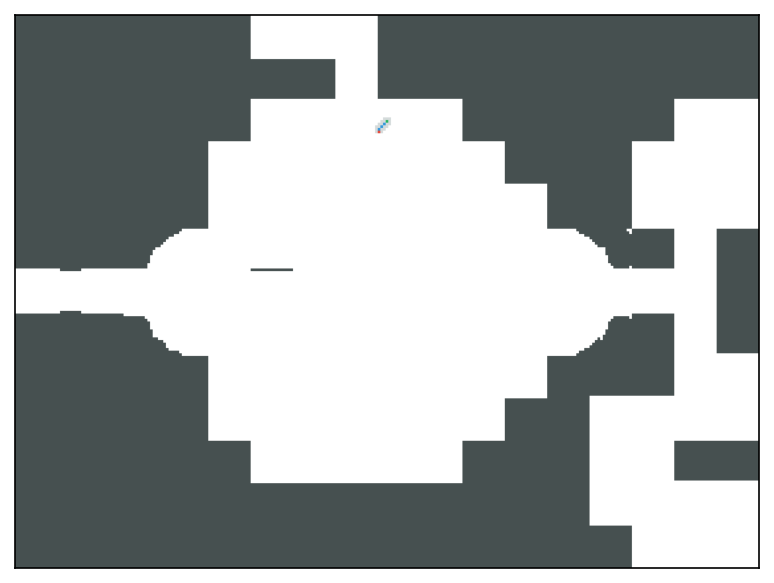

Path found! Length: 5.242639. Search tree size: 29. Number of steps: 5. Correct: True
CPU times: user 425 ms, sys: 0 ns, total: 425 ms
Wall time: 428 ms


In [43]:
%time res = simple_test(astar, 15, 'data/dao-map/arena2.map', octile_distance, SearchTreePQD)

## Running tests and gathering statistical data
Run every cell only once and use saved data (it runs 1 hour on my laptop)

In [44]:
# Use it only once

# wastar_statistic = {
#     1: [],
#     1.05: [],
#     1.1: [],
#     1.5: [],
#     2: [],
#     3: [],
#     5: []
# }
# for weight in wastar_statistic.keys():
#     for i in range(3):
#         wastar_statistic[weight].append(massive_test(wastar, 'data/', i, octile_distance, SearchTreePQD, weight))
    
    
# with open("stat/wastar_stat.txt", 'w') as file:
#     file.write(json.dumps(wastar_statistic))

To get statistical data in future we will read it from file:

In [45]:
wastar_statistic = json.loads(open("stat/wastar_stat.txt", "r").read())

wastar_statistic["1"][0].keys()

dict_keys(['corr', 'len', 'st_size', 'steps', 'time', 'map_name'])

# Let's go StAtIsTiC!

## % of path lenght correctness

<BarContainer object of 7 artists>

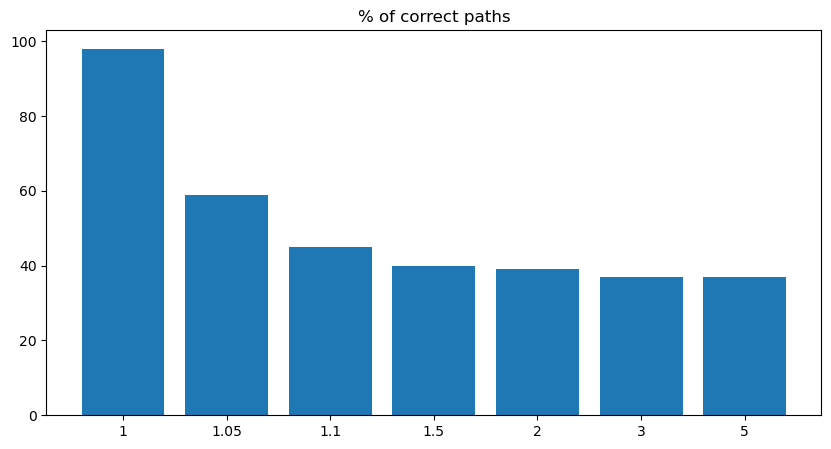

In [46]:
NUMBER_OF_TASKS = 100
NUMBER_OF_TRIALS = 3

correct_paths = {key: 0 for key in wastar_statistic.keys()}

for i in range(NUMBER_OF_TRIALS):
    for j in range(NUMBER_OF_TASKS):
        for w in correct_paths.keys():
            correct_paths[w] += wastar_statistic[w][i]["corr"][j]
        
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.set_title("% of correct paths")
ax.bar(correct_paths.keys(), [value//NUMBER_OF_TRIALS for value in correct_paths.values()])

WA* with weight 1 <=> Default A* so we expect it to be 100% correct.

As the weight for the heuristic function increases, the number of correct answers decreases. This is not surprising -- as the minimum threshold increases, the probability of obtaining an optimal solution from the first matching result decreases. 

All 1.5+ weighted algorithms seems to have around 40% of correct lenghs. This may be because there are enough straighforward paths with no obstacles, and the first matching path is correct path. 

## Path legnths

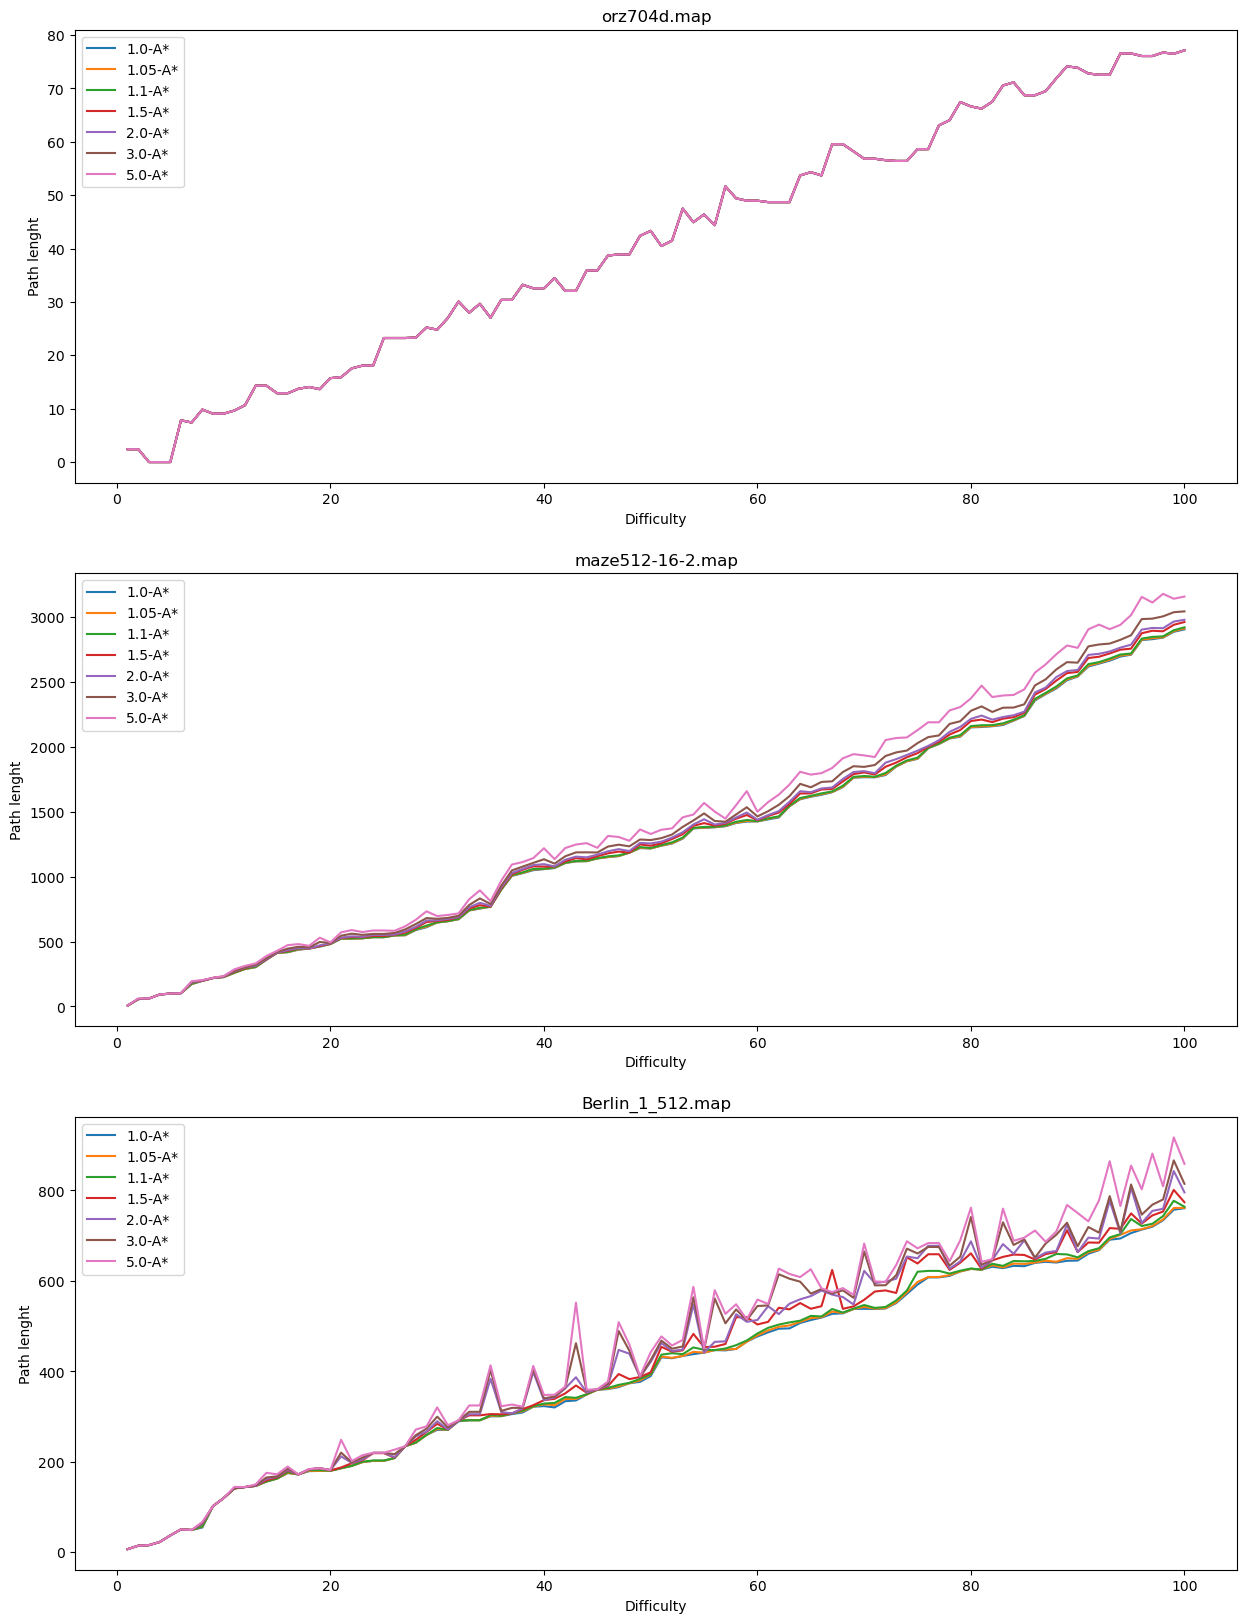

In [47]:
fig, ax = plt.subplots(3,1,figsize=(15,20))

x = [i for i in range(1, NUMBER_OF_TASKS+1)]

y_weights = {key: [] for key in wastar_statistic.keys()}
map_names = []

for i in range(NUMBER_OF_TRIALS):
    for w in y_weights.keys():
        y_weights[w].append(wastar_statistic[w][i]["len"])

        ax[i].plot(x, y_weights[w][i], label=f"{float(w)}-A*")
    
    ax[i].legend()
    
    ax[i].set_xlabel('Difficulty',fontsize = 10)
    ax[i].set_ylabel('Path lenght',fontsize = 10)
    map_names.append(wastar_statistic["1"][i]["map_name"][0])
    
    
ax[0].set_title(map_names[0])
ax[1].set_title(map_names[1])
ax[2].set_title(map_names[2])

plt.show()

As we see, the experimental path lenghts (>1) are differ from real (1.0), but not too high -- only by tenths of percent. More weight -- more lenght.

## Number of steps
Difficulty is scaled lenght i.e. len1 < len2 <=> path2 is harder then path1  

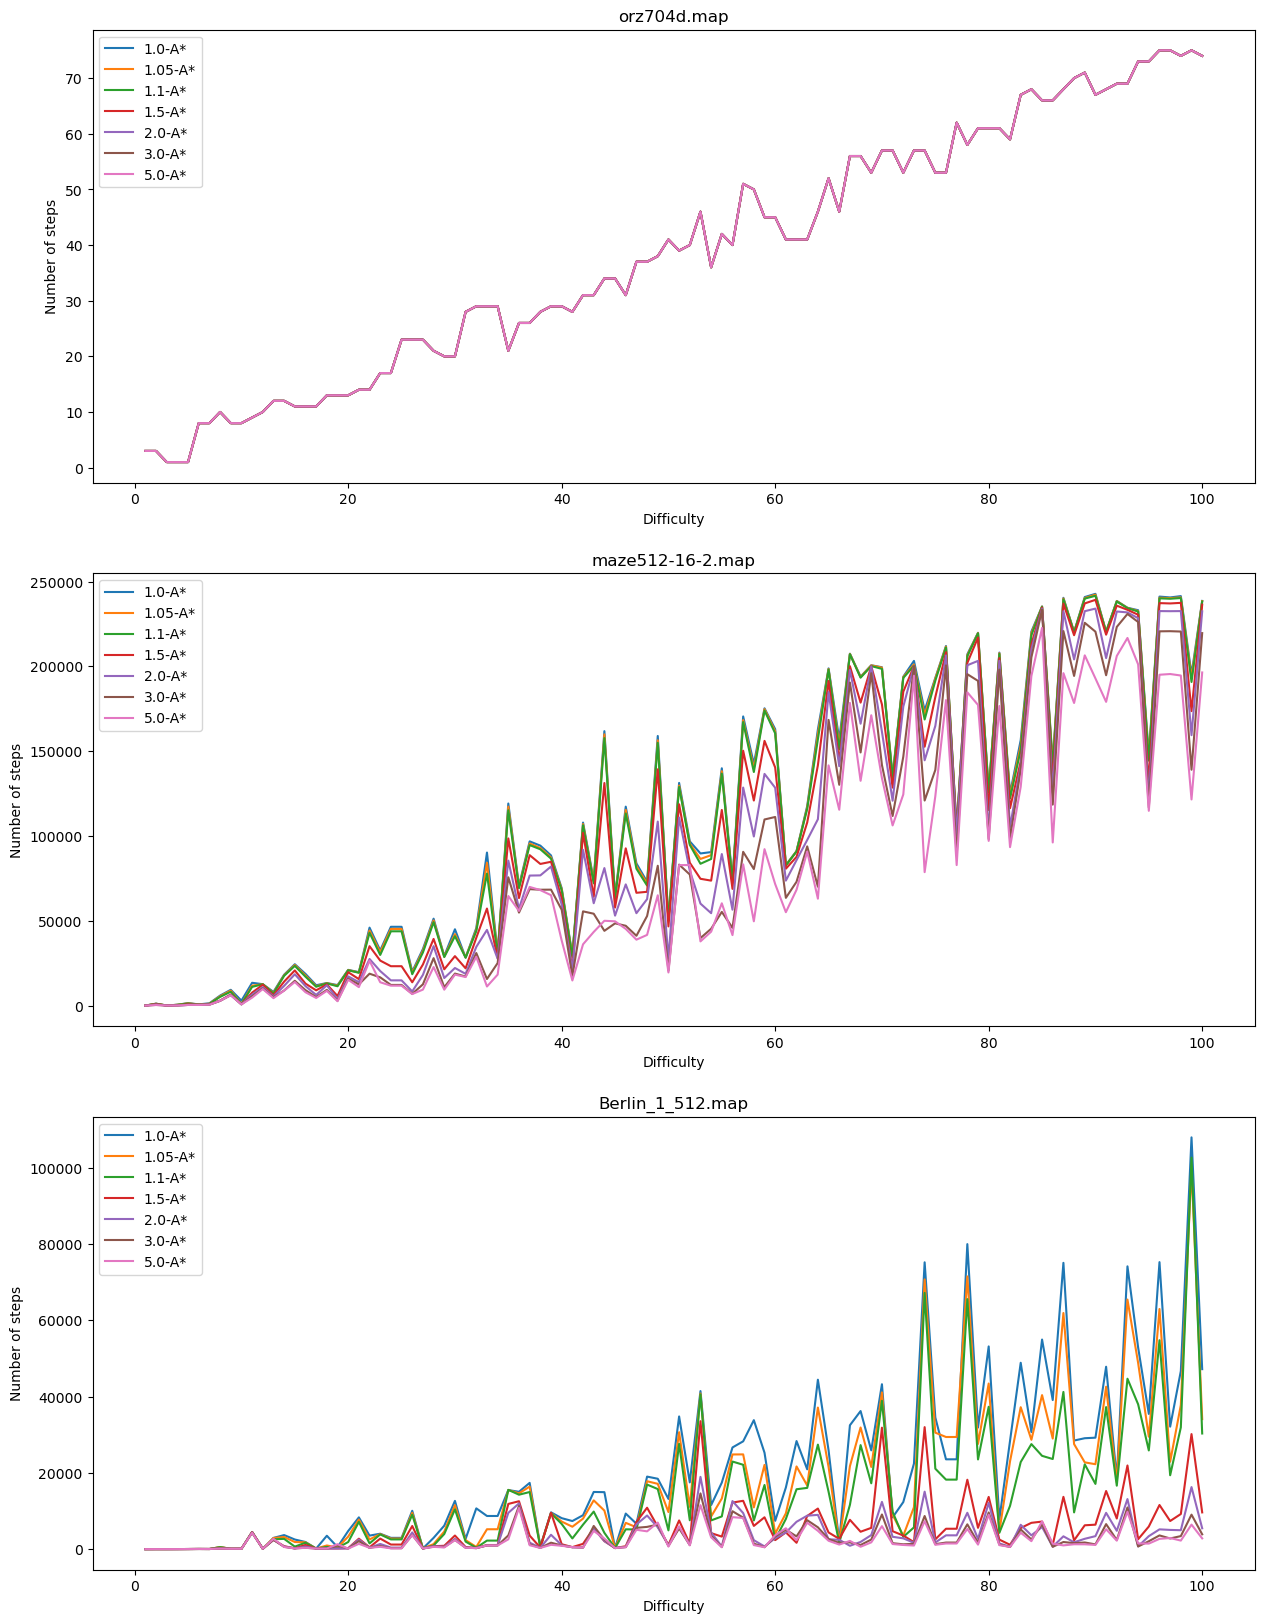

In [48]:
fig, ax = plt.subplots(3,1,figsize=(15,20))

x = [i for i in range(1, NUMBER_OF_TASKS+1)]

y_weights = {key: [] for key in wastar_statistic.keys()}
map_names = []

for i in range(NUMBER_OF_TRIALS):
    for w in y_weights.keys():
        y_weights[w].append(wastar_statistic[w][i]["steps"])

        ax[i].plot(x, y_weights[w][i], label=f"{float(w)}-A*")
    
    ax[i].legend()
    
    ax[i].set_xlabel('Difficulty',fontsize = 10)
    ax[i].set_ylabel('Number of steps',fontsize = 10)
    map_names.append(wastar_statistic["1"][i]["map_name"][0])
    
    
ax[0].set_title(map_names[0])
ax[1].set_title(map_names[1])
ax[2].set_title(map_names[2])

plt.show()

- Dao map (orz04) has few obstacles and is quite straightforward, so it seems that all algorithms find the correct path.
- On maze(maze512) and street(Berlin) maps algorithms arranges as we expect -- more weight less steps.  

## Execution Time
This parametern rely on hardware and is therefore biased, but it is still a good measure of the performance of the algorithm. 

My laptopl configuration is **AMD Ryzen 5 3500U** and **12 GB of RAM**

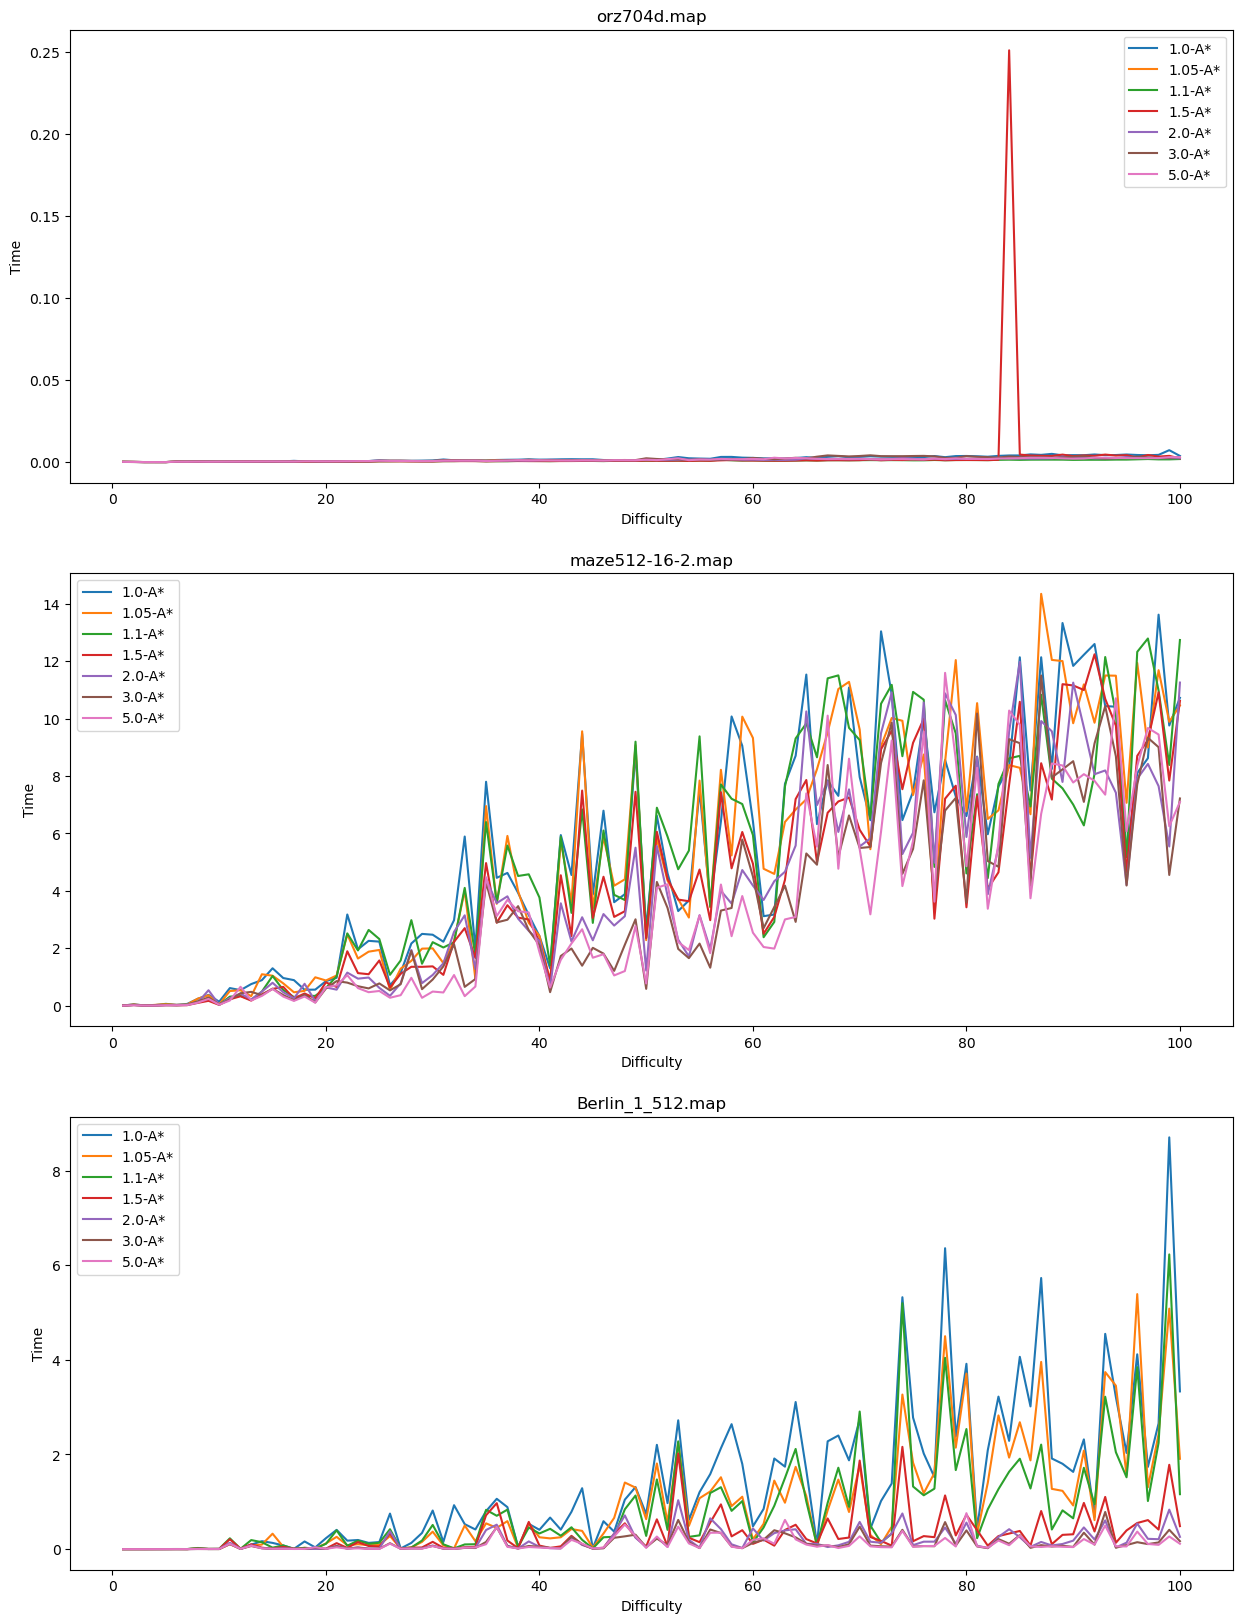

In [51]:
fig, ax = plt.subplots(3,1,figsize=(15,20))

x = [i for i in range(1, NUMBER_OF_TASKS+1)]

y_weights = {key: [] for key in wastar_statistic.keys()}
map_names = []

for i in range(NUMBER_OF_TRIALS):
    for w in y_weights.keys():
        y_weights[w].append(wastar_statistic[w][i]["time"])

        ax[i].plot(x, y_weights[w][i], label=f"{float(w)}-A*")
    
    ax[i].legend()
    
    ax[i].set_xlabel('Difficulty',fontsize = 10)
    ax[i].set_ylabel('Time',fontsize = 10)
    map_names.append(wastar_statistic["1"][i]["map_name"][0])

ax[0].set_title(map_names[0])
ax[1].set_title(map_names[1])
ax[2].set_title(map_names[2])

plt.show()

(Firsly, we exclude the weird jump of 1.5-A* on the orz map)

The benchmarking results indicate a clear correlation between the weight value used in the sub-optimal A* algorithm and the execution time. As the weight value increases, the algorithm's computational efficiency improves, leading to shorter execution times. This correlation can be attributed to the fact that higher weight values prioritize the heuristic component of the cost calculation, reducing the number of nodes expanded and consequently decreasing the overall computation required. However, it is important to note that increasing the weight value also lead to sub-optimal or longer paths being chosen on "hard" maps. 

## Box plots

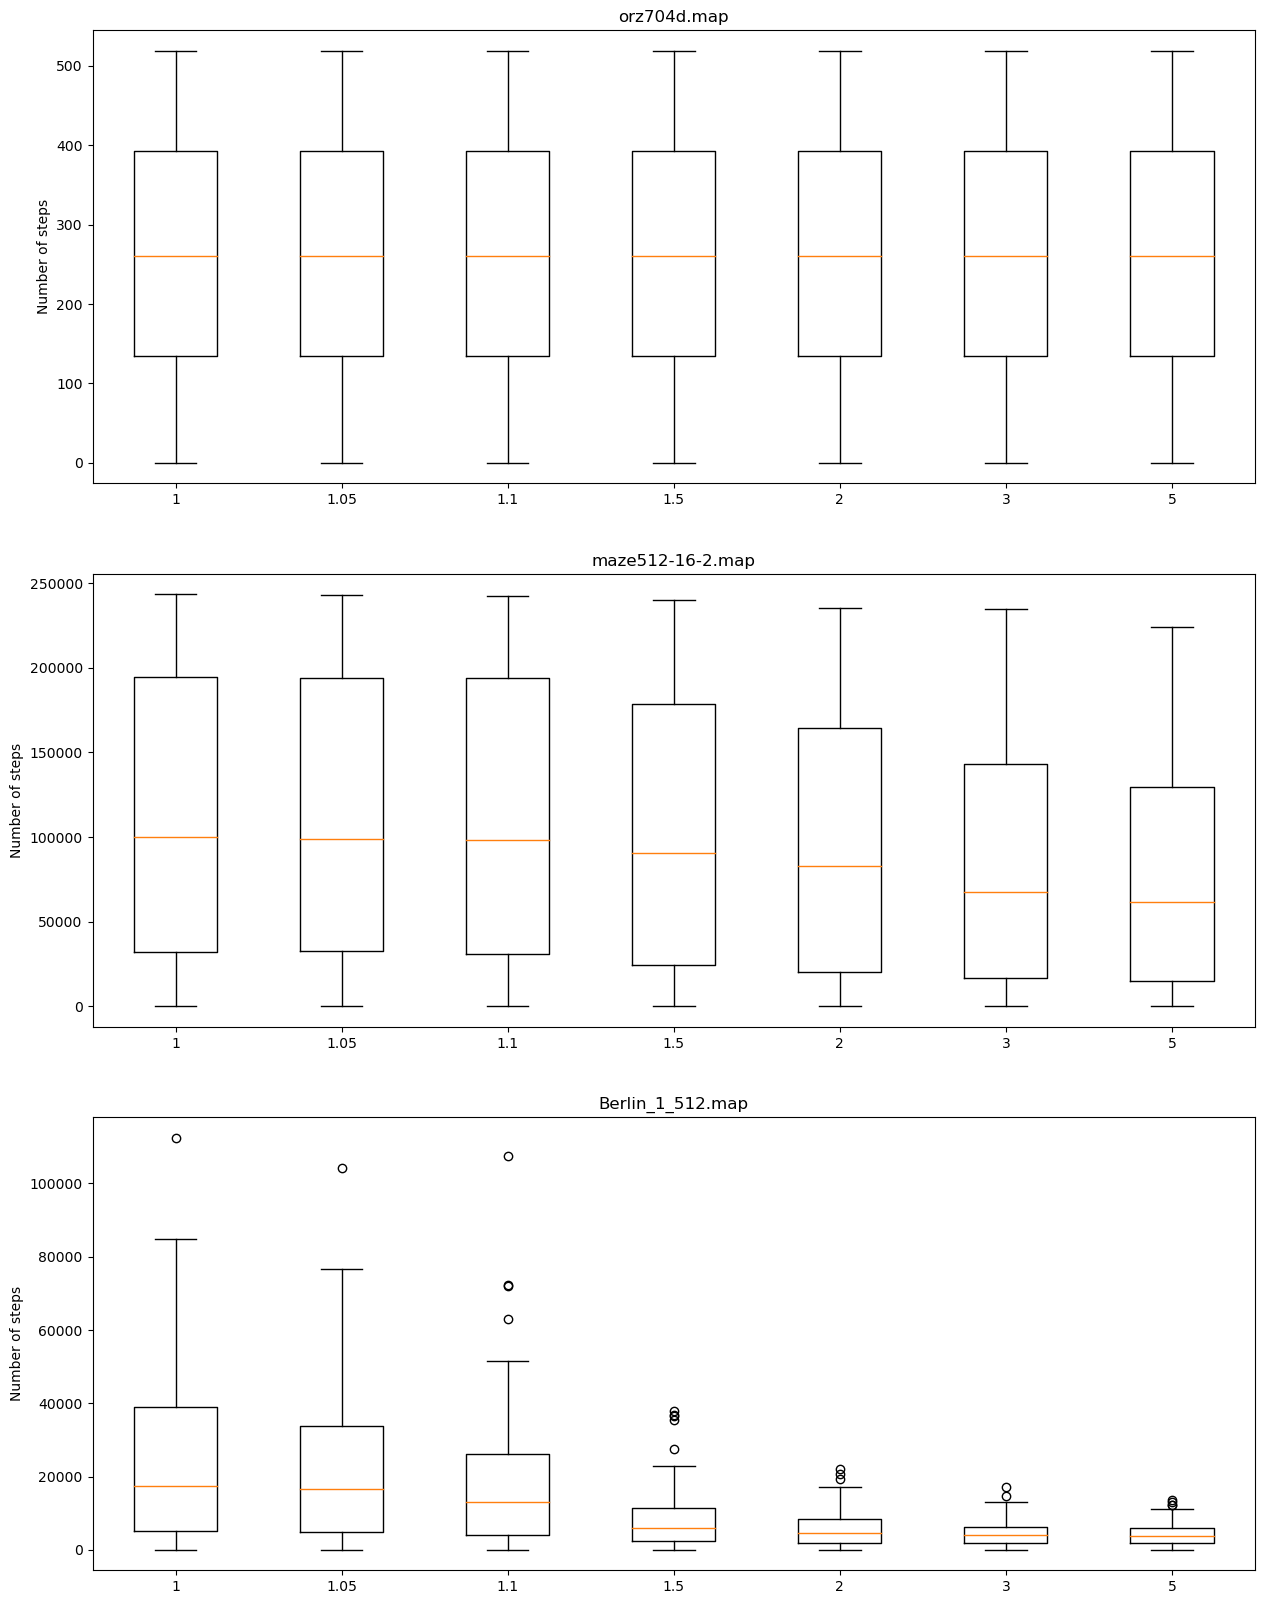

In [50]:
fig, ax = plt.subplots(3,1,figsize=(15,20))

y_weights = {key: [] for key in wastar_statistic.keys()}
map_names = []

for i in range(NUMBER_OF_TRIALS):
    for w in y_weights.keys():
        y_weights[w].append(wastar_statistic[w][i]["st_size"])
    
    ax[i].boxplot([y[i] for y in y_weights.values()]
                  , labels=y_weights.keys())
    
    ax[i].set_ylabel('Number of steps',fontsize = 10)
    map_names.append(wastar_statistic["1"][i]["map_name"][0])
    
ax[0].set_title(map_names[0])
ax[1].set_title(map_names[1])
ax[2].set_title(map_names[2])

plt.show()

As we increase weight, the size of search tree decreases fast enough on "hard" maps. It's the reason, why we sucrifice accuracy in WA* for the speed and memory reduction.

# Conclusion


**Pros:**
- Improved computational efficiency: The use of a weight value in the A* algorithm can significantly reduce execution times by prioritizing the heuristic component of the cost calculation and reducing the number of nodes expanded.
- Faster pathfinding: With higher weight values, the algorithm tends to find shorter paths more quickly, making it suitable for scenarios where finding an optimal path is not the primary concern.

**Cons:**
- Potential sub-optimality: Increasing the weight value may result in the algorithm choosing sub-optimal or longer paths. This can be a disadvantage in scenarios where finding the optimal path is crucial.
- Path optimality trade-off: Striking the right balance between computational efficiency and path optimality can be challenging, as higher weight values improve efficiency but may sacrifice path quality.
- Scenario-dependent: The effectiveness of the weighted A* algorithm depends on the specific pathfinding scenario, and careful consideration is required to determine the appropriate weight value.